
# *Support Vector Machines*

SVMs use linear algebra to find an (n-1)-dimensional boundary that separates classes within an n-dimensional space. In practical terms, this technique provides a conceptually simple way to predict class membership from a set of features. 

The standard (linear) SVM is immediately applicable to linear classification problems. Furthermore, by applying transformations to the feature space it is possible to tackle nonlinear classification problems. These transforms are called *kernels*.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# datasets and model prep
from sklearn import datasets # to import sklearn datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest # use a simple option for now
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
# models
from sklearn.linear_model import LinearRegression, LogisticRegression # model
from sklearn.svm import SVC

# model evaluation
from sklearn.inspection import DecisionBoundaryDisplay # to plot the decision boundary
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay, roc_curve, get_scorer_names,\
                            classification_report, confusion_matrix ,ConfusionMatrixDisplay, auc # review model metrics


seed = 1234

In [2]:
breast_cancer_csv = 'breast-cancer-wisconsin-data.csv'

### 2. EDA 

- Explore dataset. Clean data (if required)
- Find features to predict class

In [3]:
df = pd.read_csv('breast-cancer-wisconsin-data.csv',index_col=0)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.shape

(569, 32)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [6]:
df = df.drop('Unnamed: 32', axis=1)

In [7]:
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [8]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [9]:
#Make the target column binary.
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})
df.head(15)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678
843786,1,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440
844359,1,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368
84458202,1,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510
844981,1,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720


### 3. Logistic Regression Model

#### 3.1 Use Logistic Regression

Use Logistic Regression and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [10]:
# Select the features and target variable
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
# Create a Logistic Regression model and fit it to the training data
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\Manish\anaconda3\envs\class2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
# predict test class:
y_pred = model.predict(X_test)
# Print the predicted test class labels
print("Predicted Test Class :\n", y_pred)
# predicted test probability:
y_pred_proba = model.predict_proba(X_test)
print("Predicted Test Probability:\n", y_pred_proba)

Predicted Test Class :
 [0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 1 0]
Predicted Test Probability:
 [[7.14180113e-01 2.85819887e-01]
 [3.23571512e-01 6.76428488e-01]
 [9.96876130e-01 3.12387003e-03]
 [1.22779242e-03 9.98772208e-01]
 [1.98946536e-01 8.01053464e-01]
 [1.06288451e-03 9.98937115e-01]
 [2.51474868e-05 9.99974853e-01]
 [1.66104486e-02 9.83389551e-01]
 [9.76946685e-01 2.30533149e-02]
 [9.91526529e-01 8.47347071e-03]
 [9.70364761e-01 2.96352390e-02]
 [1.22504452e-01 8.77495548e-01]
 [1.55458391e-01 8.44541609e-01]
 [9.83574836e-01 1.64251645e-02]
 [7.81224245e-01 2.18775755e-01]
 [8.83850378e-01 1.16149622e-01]
 [9.72264284e-01 2.77357156e-02]
 [9.77128041e-01 2.28719589e-02]
 [9.99189121e-01 8.10878773e-04]
 [1.14517018e-06 9.99998855e-01]
 [9.90292769e-01 9.70723107e-03]
 [9.53658374e-01 4.63

In [23]:
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)
# Print the evaluation metrics
print("Accuracy Score:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification)

Accuracy Score: 0.9473684210526315
Confusion Matrix:
[[70  2]
 [ 4 38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



### 4. Support Vector Machine

#### 4.1 Use Support Vector Machine

Use Support Vector Machine and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [24]:
# Create an instance for SVM
svm= SVC()

In [25]:
# Fit the model on the training data
svm.fit(X_train, y_train)

SVC()

In [26]:
# Make predictions on the test data
y_pred_1 = svm.predict(X_test)

In [27]:
# Evaluate the model
accuracy_1 = accuracy_score(y_test, y_pred_1)
confusion_1 = confusion_matrix(y_test, y_pred_1)
classification_1 = classification_report(y_test, y_pred_1)
# Print the evaluation metrics
print("Accuracy Score:", accuracy_1)
print("Confusion Matrix:")
print(confusion_1)
print("Classification Report:")
print(classification_1)

Accuracy Score: 0.9035087719298246
Confusion Matrix:
[[72  0]
 [11 31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        72
           1       1.00      0.74      0.85        42

    accuracy                           0.90       114
   macro avg       0.93      0.87      0.89       114
weighted avg       0.92      0.90      0.90       114



### 5. Naive Bayes
#### 5.1 Use Naive Bayes

Use Naive Bayes and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [30]:
# Create an instance for Naive Bayes (GaussianNB)
naive_bayes= GaussianNB()

In [31]:
# Fit the model on the training data
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [32]:
# Make predictions on the test data
y_pred_2 = naive_bayes.predict(X_test)

In [33]:
# Evaluate the model
accuracy_2 = accuracy_score(y_test, y_pred)
confusion_2 = confusion_matrix(y_test, y_pred)
classification_2 = classification_report(y_test, y_pred_2)
# Print the evaluation metrics
print("Accuracy Score:", accuracy_2)
print("Confusion Matrix:")
print(confusion_2)
print("Classification Report:")
print(classification_2)

Accuracy Score: 0.9473684210526315
Confusion Matrix:
[[70  2]
 [ 4 38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



### 6 Gridsearch optimal parameters for all three models.

Is there any difference between accuracy score of Logistic Regression and SVM? Use grid serach to find optimal parameter for both these models.

> Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

> It is possible and recommended to search the hyper-parameter space for the best cross validation score.

> https://scikit-learn.org/stable/modules/grid_search.html#grid-search

**Note:** It'll take time to execute this. After running the cell, wait for result.

#### 6.1 Find Best Estimator For Logistic Regression 

Find out how these parameters effect model. Find out the best estimator, score.

In [38]:
lr_params = {
    'penalty': ['l1','l2'],
    'C': [1, 10, 100]
}
# Perform grid search to find the best estimator
grid_search = GridSearchCV(model, lr_params, cv=5)
grid_search.fit(X_train, y_train)
# Get the best estimator and its score
best_estimator = grid_search.best_estimator_
best_score = grid_search.best_score_
# Print the best estimator and its score
print("Best Estimator:", best_estimator)
print("Best Score:", best_score)

C:\Users\Manish\anaconda3\envs\class2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Manish\anaconda3\envs\class2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Best Estimator: LogisticRegression(C=1)
Best Score: 0.9472527472527472


C:\Users\Manish\anaconda3\envs\class2\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan 0.94725275        nan 0.94285714        nan 0.94065934]
  warnings.warn(
C:\Users\Manish\anaconda3\envs\class2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 6.2 Find Best Estimator For SVM

Find out how these parameters effect model. Find out the best estimator, score.

In [41]:
svc_params = {'penalty': ['l1','l2'],
    'C': [1, 10, 100]
}

# Perform grid search to find the best estimator
grid_search = GridSearchCV(model, svc_params, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator and its score
best_estimator_1 = grid_search.best_estimator_
best_score_1 = grid_search.best_score_

# Print the best estimator and its score
print("Best Estimator:", best_estimator_1)
print("Best Score:", best_score_1)

C:\Users\Manish\anaconda3\envs\class2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Manish\anaconda3\envs\class2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Best Estimator: LogisticRegression(C=1)
Best Score: 0.9472527472527472


C:\Users\Manish\anaconda3\envs\class2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Manish\anaconda3\envs\class2\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed w

#### 6.3 Plot the ROC curve for the SVM, Logistic Regressions and Naive Bayes on the same plot

Find out which model performs better.

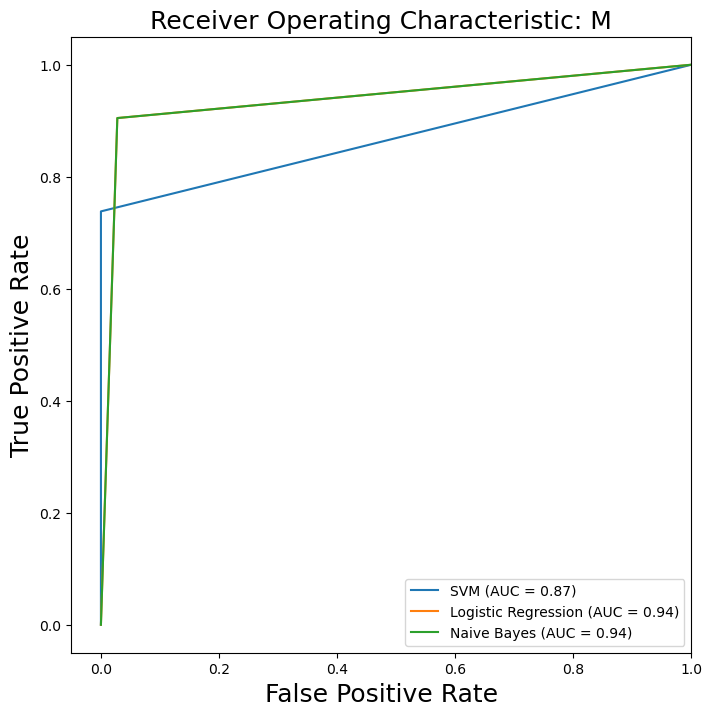

In [50]:
# Calculate the false positive rate, true positive rate, and threshold for each model
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, y_pred_1)
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_test, y_pred)
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, y_pred_2)

# Calculate the AUC (Area Under the Curve) for each model
svm_auc = auc(svm_fpr, svm_tpr)
logreg_auc = auc(logreg_fpr, logreg_tpr)
nb_auc = auc(nb_fpr, nb_tpr)

plt.figure(figsize=[8,8])
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic: M', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### 7. [BONUS] Learning Curve

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.

Plot "learning curves" for the best models of each. This is a great way see how training/testing size affects the scores. Look at the documentation for how to use this function in sklearn.

http://scikit-learn.org/stable/modules/learning_curve.html#learning-curves

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)

[Validation curves: plotting scores to evaluate models](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curves)

[In-Depth: Support Vector Machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

[Understanding Support Vector Machine algorithm from examples (along with code)](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)

[Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)



---



---



> > > > > > > > > © 2023 Institute of Data


---



---



